<a href="https://colab.research.google.com/github/StarBlossom99/Pytorch_Study/blob/main/2022_0215/pytorch_study_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://download.pytorch.org/tutorial/data.zip

데이터


In [61]:
%matplotlib inline

In [62]:
!unzip -qq /content/data.zip

replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/names/Arabic.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [78]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

# 해당 형식의 파일 주소들을 모두 출력
print(findFiles('data/names/*.txt'))

import unicodedata
import string

# 알파벳 대소문자 + " .,;'"
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) # 유니코드 문자열에 대한 normal form을 반환
        if unicodedata.category(c) != 'Mn' # 문자에 할당된 general category를 문자열로 반환
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {} # 카테고리마다 리스트, 인덱스가 카테고리
all_categories = [] # 언어 목록

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    # print(all_categories)
    lines = readLines(filename)
    # print(lines)
    category_lines[category] = lines

n_categories = len(all_categories) # 언어의 개수
print(n_categories)

['data/names/Russian.txt', 'data/names/Chinese.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Irish.txt', 'data/names/Vietnamese.txt', 'data/names/Korean.txt', 'data/names/Spanish.txt', 'data/names/Italian.txt', 'data/names/Dutch.txt', 'data/names/Portuguese.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Greek.txt', 'data/names/Polish.txt', 'data/names/Arabic.txt']
Slusarski
18


['data/names/Russian.txt', 'data/names/Chinese.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Irish.txt', 'data/names/Vietnamese.txt', 'data/names/Korean.txt', 'data/names/Spanish.txt', 'data/names/Italian.txt', 'data/names/Dutch.txt', 'data/names/Portuguese.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Greek.txt', 'data/names/Polish.txt', 'data/names/Arabic.txt']
Slusarski
18

glob 는 무엇?


In [79]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [80]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())
# 5 * 1 * 57(26 + 26 + " .,;'"(5))


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [81]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [82]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [83]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8174, -2.9235, -2.8679, -2.8037, -2.8989, -2.9743, -2.9438, -2.8685,
         -2.9523, -2.8776, -2.9274, -2.8093, -2.9489, -2.8561, -2.8894, -2.7938,
         -2.9977, -2.9076]], grad_fn=<LogSoftmaxBackward0>)


In [84]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 15)


텐서의 가장 큰 값 및 주소를 구한다.

텐서에서 정수값으로 변경한 뒤에 카테고리와 함께 출력

In [85]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Braden
category = Irish / line = O'Boyle
category = Czech / line = Geier
category = Korean / line = Chong
category = Spanish / line = Mateu
category = Greek / line = Adamidis
category = Portuguese / line = Pereira
category = Korean / line = Ron
category = Dutch / line = Tunneson
category = Czech / line = Glockl


In [86]:
criterion = nn.NLLLoss()

In [87]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    # print(line_tensor.size()[0])
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [88]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.3536 Trieu / Vietnamese ✓
10000 10% (0m 10s) 2.3907 Kouba / Arabic ✗ (Czech)
15000 15% (0m 16s) 0.6651 Harahinov / Russian ✓
20000 20% (0m 21s) 1.2069 Corvi / Italian ✓
25000 25% (0m 27s) 1.1801 Chu / Chinese ✗ (Vietnamese)
30000 30% (0m 32s) 0.6959 Isachenok / Russian ✓
35000 35% (0m 38s) 1.4234 Doherty / Irish ✓
40000 40% (0m 43s) 0.1732 O'Donnell / Irish ✓
45000 45% (0m 49s) 0.8106 Chun / Korean ✓
50000 50% (0m 54s) 1.5872 Stroggylis / Scottish ✗ (Greek)
55000 55% (0m 59s) 0.4133 O'Dell / Irish ✓
60000 60% (1m 5s) 1.4076 Trennery / Dutch ✗ (English)
65000 65% (1m 11s) 3.7021 Maas / Arabic ✗ (Dutch)
70000 70% (1m 16s) 5.1083 Tos / Vietnamese ✗ (Spanish)
75000 75% (1m 22s) 0.6434 Kurkawa / Japanese ✓
80000 80% (1m 28s) 0.6198 Schreier / German ✓
85000 85% (1m 34s) 0.4506 Qiu / Chinese ✓
90000 90% (1m 40s) 0.3130 Hajjar / Arabic ✓
95000 95% (1m 45s) 0.1269 O'Gorman / Irish ✓
100000 100% (1m 51s) 1.2423 Almasi / Italian ✗ (Arabic)


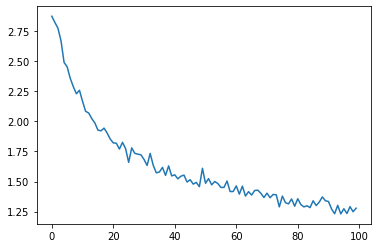

In [89]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

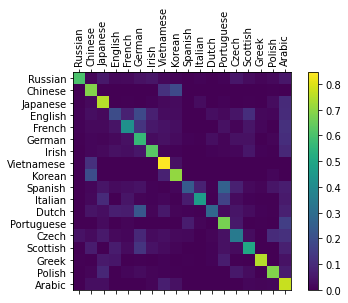

In [90]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [93]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Lukas')
predict('Lee')
predict('Peterson')
predict('Martin')


> Lukas
(-0.89) Greek
(-1.77) Vietnamese
(-2.51) Chinese

> Lee
(-0.84) Chinese
(-0.87) Vietnamese
(-3.04) Korean

> Peterson
(-0.62) Scottish
(-1.68) English
(-2.33) German

> Martin
(-0.35) Arabic
(-2.12) Irish
(-3.41) French
